<a href="https://colab.research.google.com/github/janakg/era-s5/blob/main/S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

In [2]:
# import os

# # Define the repository and the target directory
# repo_url = 'https://github.com/janakg/era-s9.git'
# target_dir = '/content/era-s9'

# # Check if the directory already exists
# if not os.path.exists(target_dir):
#     # If it doesn't exist, clone the repo
#     !git clone {repo_url}
# else:
#     # If it exists, 'cd' into the directory and pull the latest changes
#     %cd {target_dir}
#     !git pull

# # Add the repository's directory to the system path
# import sys
# sys.path.append(target_dir)

# Import all utils functions
from utils import *

In [3]:
# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)


# For reproducibility. SEED Random functions
SEED = 1
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available? True


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [5]:
train_data = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


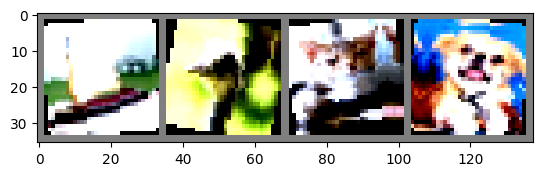

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# # Call the util function to show a batch of images
# import matplotlib.pyplot as plt
# fig = plt.figure()
# show_batch_images(plt, train_loader, 12, 3, 4)

In [8]:
# model imported from a module
from model import Net

In [9]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Pre-gap size: torch.Size([2, 32, 32, 32])
Post-gap size: torch.Size([2, 32, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 32, 32, 32]          18,432
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
             ReLU-12           [-1, 32, 32, 32]               0
      BatchNorm2d-13

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 1

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_succeeded, train_processed, train_loss = train(model, device, train_loader, optimizer, criterion)
  train_acc.append(100 * train_succeeded/train_processed)
  train_losses.append(train_loss / len(train_loader))

  test_succeeded, test_loss = test(model, device, test_loader, criterion)
  test_acc.append(100. * test_succeeded / len(test_loader.dataset))
  test_losses.append(test_loss)

  # scheduler.step()

Epoch 1


  0%|          | 0/98 [00:00<?, ?it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.3104 Batch_id=0 Accuracy=7.42:   1%|          | 1/98 [00:01<01:44,  1.08s/it]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.3030 Batch_id=2 Accuracy=8.59:   3%|▎         | 3/98 [00:01<00:38,  2.48it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.2924 Batch_id=3 Accuracy=9.57:   4%|▍         | 4/98 [00:01<00:30,  3.07it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.2885 Batch_id=4 Accuracy=9.80:   5%|▌         | 5/98 [00:01<00:26,  3.53it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.2631 Batch_id=6 Accuracy=11.50:   7%|▋         | 7/98 [00:02<00:22,  4.13it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.2416 Batch_id=7 Accuracy=12.26:   8%|▊         | 8/98 [00:02<00:20,  4.34it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.2314 Batch_id=8 Accuracy=13.15:   9%|▉         | 9/98 [00:02<00:19,  4.49it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.2092 Batch_id=9 Accuracy=14.04:  10%|█         | 10/98 [00:02<00:19,  4.60it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.1890 Batch_id=10 Accuracy=14.68:  11%|█         | 11/98 [00:03<00:18,  4.64it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.1655 Batch_id=11 Accuracy=15.40:  12%|█▏        | 12/98 [00:03<00:18,  4.69it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.1882 Batch_id=12 Accuracy=15.56:  13%|█▎        | 13/98 [00:03<00:17,  4.74it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.1484 Batch_id=13 Accuracy=15.88:  14%|█▍        | 14/98 [00:03<00:17,  4.77it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.1130 Batch_id=14 Accuracy=16.35:  15%|█▌        | 15/98 [00:03<00:17,  4.79it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.1014 Batch_id=15 Accuracy=16.75:  16%|█▋        | 16/98 [00:04<00:17,  4.80it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.1042 Batch_id=16 Accuracy=17.11:  17%|█▋        | 17/98 [00:04<00:16,  4.82it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.0399 Batch_id=17 Accuracy=17.64:  18%|█▊        | 18/98 [00:04<00:16,  4.83it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.0318 Batch_id=18 Accuracy=18.17:  19%|█▉        | 19/98 [00:04<00:16,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.0182 Batch_id=20 Accuracy=18.79:  21%|██▏       | 21/98 [00:05<00:15,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9957 Batch_id=21 Accuracy=19.11:  22%|██▏       | 22/98 [00:05<00:15,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=2.0017 Batch_id=22 Accuracy=19.29:  23%|██▎       | 23/98 [00:05<00:15,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9843 Batch_id=23 Accuracy=19.59:  24%|██▍       | 24/98 [00:05<00:15,  4.86it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9576 Batch_id=24 Accuracy=19.80:  26%|██▌       | 25/98 [00:06<00:15,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9996 Batch_id=25 Accuracy=19.91:  27%|██▋       | 26/98 [00:06<00:14,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9514 Batch_id=26 Accuracy=20.31:  28%|██▊       | 27/98 [00:06<00:14,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9398 Batch_id=27 Accuracy=20.63:  29%|██▊       | 28/98 [00:06<00:14,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9458 Batch_id=28 Accuracy=20.91:  30%|██▉       | 29/98 [00:06<00:14,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9375 Batch_id=29 Accuracy=21.09:  31%|███       | 30/98 [00:07<00:14,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9357 Batch_id=30 Accuracy=21.32:  32%|███▏      | 31/98 [00:07<00:13,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9452 Batch_id=31 Accuracy=21.34:  33%|███▎      | 32/98 [00:07<00:13,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8904 Batch_id=32 Accuracy=21.56:  34%|███▎      | 33/98 [00:07<00:13,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9146 Batch_id=33 Accuracy=21.72:  35%|███▍      | 34/98 [00:07<00:13,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8720 Batch_id=34 Accuracy=21.91:  36%|███▌      | 35/98 [00:08<00:13,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8530 Batch_id=35 Accuracy=22.18:  37%|███▋      | 36/98 [00:08<00:12,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8553 Batch_id=36 Accuracy=22.38:  38%|███▊      | 37/98 [00:08<00:12,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8491 Batch_id=37 Accuracy=22.58:  39%|███▉      | 38/98 [00:08<00:12,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8593 Batch_id=38 Accuracy=22.77:  40%|███▉      | 39/98 [00:08<00:12,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8343 Batch_id=39 Accuracy=22.99:  41%|████      | 40/98 [00:09<00:11,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8689 Batch_id=40 Accuracy=23.22:  42%|████▏     | 41/98 [00:09<00:11,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8760 Batch_id=41 Accuracy=23.37:  43%|████▎     | 42/98 [00:09<00:11,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8401 Batch_id=42 Accuracy=23.58:  44%|████▍     | 43/98 [00:09<00:11,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.9006 Batch_id=43 Accuracy=23.72:  45%|████▍     | 44/98 [00:09<00:11,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8052 Batch_id=44 Accuracy=23.91:  46%|████▌     | 45/98 [00:10<00:10,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8328 Batch_id=45 Accuracy=24.04:  47%|████▋     | 46/98 [00:10<00:10,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7987 Batch_id=46 Accuracy=24.24:  48%|████▊     | 47/98 [00:10<00:10,  4.83it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8383 Batch_id=48 Accuracy=24.57:  50%|█████     | 49/98 [00:10<00:10,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8340 Batch_id=49 Accuracy=24.68:  51%|█████     | 50/98 [00:11<00:09,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7722 Batch_id=50 Accuracy=24.87:  52%|█████▏    | 51/98 [00:11<00:09,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7893 Batch_id=51 Accuracy=24.99:  53%|█████▎    | 52/98 [00:11<00:09,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8140 Batch_id=52 Accuracy=25.11:  54%|█████▍    | 53/98 [00:11<00:09,  4.83it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7955 Batch_id=53 Accuracy=25.31:  55%|█████▌    | 54/98 [00:12<00:09,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.8006 Batch_id=54 Accuracy=25.46:  56%|█████▌    | 55/98 [00:12<00:08,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7984 Batch_id=55 Accuracy=25.55:  57%|█████▋    | 56/98 [00:12<00:08,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7548 Batch_id=56 Accuracy=25.72:  58%|█████▊    | 57/98 [00:12<00:08,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7736 Batch_id=57 Accuracy=25.83:  59%|█████▉    | 58/98 [00:12<00:08,  4.83it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7716 Batch_id=58 Accuracy=26.00:  60%|██████    | 59/98 [00:13<00:08,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7480 Batch_id=59 Accuracy=26.16:  61%|██████    | 60/98 [00:13<00:07,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7265 Batch_id=60 Accuracy=26.34:  62%|██████▏   | 61/98 [00:13<00:07,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7948 Batch_id=61 Accuracy=26.45:  63%|██████▎   | 62/98 [00:13<00:07,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7353 Batch_id=62 Accuracy=26.59:  64%|██████▍   | 63/98 [00:13<00:07,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6883 Batch_id=63 Accuracy=26.78:  65%|██████▌   | 64/98 [00:14<00:07,  4.86it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6900 Batch_id=64 Accuracy=26.94:  66%|██████▋   | 65/98 [00:14<00:06,  4.86it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7305 Batch_id=65 Accuracy=27.02:  67%|██████▋   | 66/98 [00:14<00:06,  4.86it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7289 Batch_id=66 Accuracy=27.10:  68%|██████▊   | 67/98 [00:14<00:06,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7273 Batch_id=67 Accuracy=27.19:  69%|██████▉   | 68/98 [00:14<00:06,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7502 Batch_id=68 Accuracy=27.30:  70%|███████   | 69/98 [00:15<00:05,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7361 Batch_id=69 Accuracy=27.42:  71%|███████▏  | 70/98 [00:15<00:05,  4.79it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7140 Batch_id=70 Accuracy=27.52:  72%|███████▏  | 71/98 [00:15<00:05,  4.81it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6701 Batch_id=72 Accuracy=27.79:  74%|███████▍  | 73/98 [00:15<00:05,  4.78it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6913 Batch_id=73 Accuracy=27.91:  76%|███████▌  | 74/98 [00:16<00:05,  4.79it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6629 Batch_id=74 Accuracy=28.01:  77%|███████▋  | 75/98 [00:16<00:04,  4.81it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.7441 Batch_id=75 Accuracy=28.06:  78%|███████▊  | 76/98 [00:16<00:04,  4.82it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6460 Batch_id=77 Accuracy=28.27:  80%|███████▉  | 78/98 [00:16<00:04,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6691 Batch_id=78 Accuracy=28.37:  81%|████████  | 79/98 [00:17<00:03,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6521 Batch_id=79 Accuracy=28.48:  82%|████████▏ | 80/98 [00:17<00:03,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6405 Batch_id=80 Accuracy=28.57:  83%|████████▎ | 81/98 [00:17<00:03,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6798 Batch_id=81 Accuracy=28.65:  84%|████████▎ | 82/98 [00:17<00:03,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6880 Batch_id=82 Accuracy=28.72:  85%|████████▍ | 83/98 [00:18<00:03,  4.86it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6524 Batch_id=83 Accuracy=28.82:  86%|████████▌ | 84/98 [00:18<00:02,  4.86it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6701 Batch_id=84 Accuracy=28.89:  87%|████████▋ | 85/98 [00:18<00:02,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6843 Batch_id=85 Accuracy=28.98:  88%|████████▊ | 86/98 [00:18<00:02,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6676 Batch_id=86 Accuracy=29.07:  89%|████████▉ | 87/98 [00:18<00:02,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6181 Batch_id=87 Accuracy=29.17:  90%|████████▉ | 88/98 [00:19<00:02,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6142 Batch_id=88 Accuracy=29.27:  91%|█████████ | 89/98 [00:19<00:01,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6244 Batch_id=89 Accuracy=29.36:  92%|█████████▏| 90/98 [00:19<00:01,  4.76it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6593 Batch_id=90 Accuracy=29.46:  93%|█████████▎| 91/98 [00:19<00:01,  4.78it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6838 Batch_id=91 Accuracy=29.56:  94%|█████████▍| 92/98 [00:19<00:01,  4.81it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6159 Batch_id=92 Accuracy=29.70:  95%|█████████▍| 93/98 [00:20<00:01,  4.82it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6380 Batch_id=93 Accuracy=29.79:  96%|█████████▌| 94/98 [00:20<00:00,  4.83it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.5757 Batch_id=94 Accuracy=29.89:  97%|█████████▋| 95/98 [00:20<00:00,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6379 Batch_id=95 Accuracy=29.97:  98%|█████████▊| 96/98 [00:20<00:00,  4.84it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6230 Batch_id=96 Accuracy=30.06:  99%|█████████▉| 97/98 [00:20<00:00,  4.85it/s]

Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])


Train: Loss=1.6570 Batch_id=97 Accuracy=30.14: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]

Pre-gap size: torch.Size([336, 32, 32, 32])
Post-gap size: torch.Size([336, 32, 1, 1])


Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])
Post-gap size: torch.Size([512, 32, 1, 1])
Pre-gap size: torch.Size([512, 32, 32, 32])

In [12]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): 

In [13]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 13
conv_layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


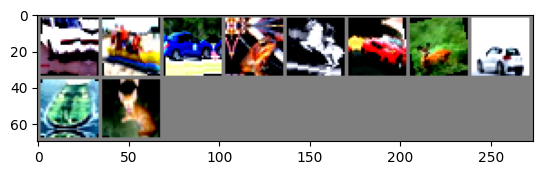

In [14]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


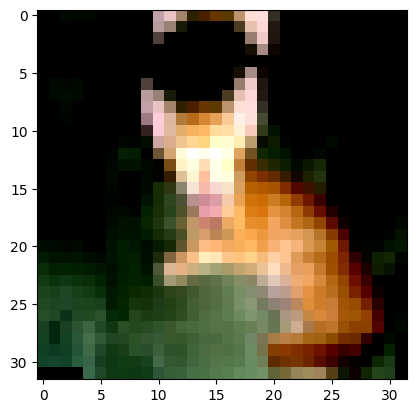

In [15]:
image = images[9]
imshow(image)

In [16]:
image = image.unsqueeze(0)
image = image.to(device)

In [17]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

13
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 10, 32, 32])


In [18]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


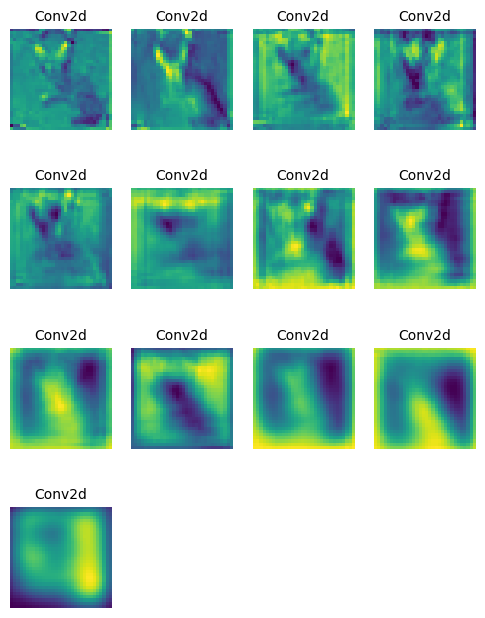

In [19]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

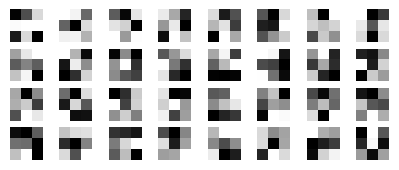

In [20]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()